In [244]:
import asyncio
from datetime import datetime, timedelta
import pandas as pd
import re
from pandas import DataFrame
import numpy as np
import json
from typing import Optional, List
from time import sleep
from collections import defaultdict
from analyst.analysis.utils import *
from analyst.crypto.models import *
from pydantic import BaseModel, Field

from tabulate import tabulate
from analyst.adapters.factory import get_adapters, Adapters
from analyst.controllers.factory import get_controllers
from analyst.repositories.factory import get_repositories
from analyst.bot.order_manager import OrderManager
from analyst.settings import get_settings
from analyst.screener import MarketMakerScreener

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
plt.rcParams['figure.figsize'] = [32, 6]
sns.set()
%matplotlib inline

In [140]:
settings = get_settings()
adapters = await get_adapters(settings=settings)
repositories = get_repositories(settings=settings, adapters=adapters)
controllers = get_controllers(adapters=adapters, repositories=repositories)
order_manager = OrderManager(controllers=controllers)
await order_manager.setup()

In [3]:
screener = MarketMakerScreener(controllers)

In [4]:
await screener.load_pairs()
await screener.load_dataframes()

In [5]:
sr = screener.run()

In [6]:
csr = sr[sr["diff"] > 1.5].copy()

In [7]:
a = (csr.assign(res=(float(csr["diff"].max()) - csr["diff"].astype(float) * 1000) + (csr["n3h"] * 10000) + (csr["1d_lvl"] * 500))
       .sort_values(["res"])
)

In [8]:
a.sort_values(by="diff")

,n2m,c2m,n1m,c1m,n7d,c7d,n1d,n3h,diff,last_1d_vol,1d_vol,2m_lvl,1m_lvl,7d_lvl,1d_lvl,ask,bid,ask_q,bid_q,b/a,fill ask,fill bid,res
symbol,,,,,,,,,,,,,,,,,,,,,,,
QKCBTC,41,358,39,263,21,91,6,3,1.538461538461538461538461538,394635547.0,262758730.0,48.780488,46.153846,25.000000,40.000000,6.6E-7,6.5E-7,4484965,6826971,1.522190474173154082584813928,58.586573,38.488333,48465.538462
IOSTBTC,12,180,11,88,5,20,3,2,1.562500,17378919.0,6498729.0,41.666667,41.666667,75.000000,100.000000,6.5E-7,6.4E-7,8799341,6883187,0.7822389199372998500683176161,0.738547,0.944145,68441.500000
BTSBTC,29,210,24,97,20,42,3,2,1.724137931034482758620689655,42235389.0,13272541.0,38.709677,32.142857,26.923077,100.000000,5.9E-7,5.8E-7,643001,2747920,4.273585888668913423151752486,20.641556,4.830032,68279.862069
PONDBTC,31,279,15,141,12,41,4,3,1.754385964912280701754385965,9377516.0,8600034.0,39.393939,57.142857,45.454545,66.666667,5.8E-7,5.7E-7,19445,3753139,193.0130624839290305991257393,442.274826,2.291424,61582.947368
QIBTC,33,274,15,98,6,17,3,2,1.923076923076923076923076923,3210540.0,12111059.0,6.250000,14.285714,40.000000,50.000000,5.3E-7,5.2E-7,410065,5354244,13.05706168534256764171533781,29.534486,2.261955,43080.923077
DGBBTC,17,201,9,67,5,10,3,2,2.00,32794965.0,32961920.0,31.250000,37.500000,75.000000,100.000000,5.1E-7,5.0E-7,6088108,4559962,0.7489949258455993224824526766,5.414148,7.228551,68004.000000
TCTBTC,32,210,17,94,7,17,3,2,2.631578947368421052631578947,24374433.0,1570403.0,6.451613,11.111111,33.333333,50.000000,3.9E-7,3.8E-7,1640492,5046162,3.076005247206325907105917005,0.957276,0.311207,42372.421053
STMXBTC,14,158,9,66,4,7,3,2,2.631578947368421052631578947,14513373.0,16379937.0,42.857143,62.500000,100.000000,100.000000,3.9E-7,3.8E-7,6055557,7522940,1.242320070639249205316703319,2.704943,2.177332,67372.421053
JASMYBTC,15,164,12,55,8,9,2,2,2.702702702702702702702702703,59246839.9,64922024.7,14.285714,18.181818,28.571429,0.000000,3.8E-7,3.7E-7,21290604,11558409,0.5428878054772367101048573332,3.049327,5.616865,17301.297297


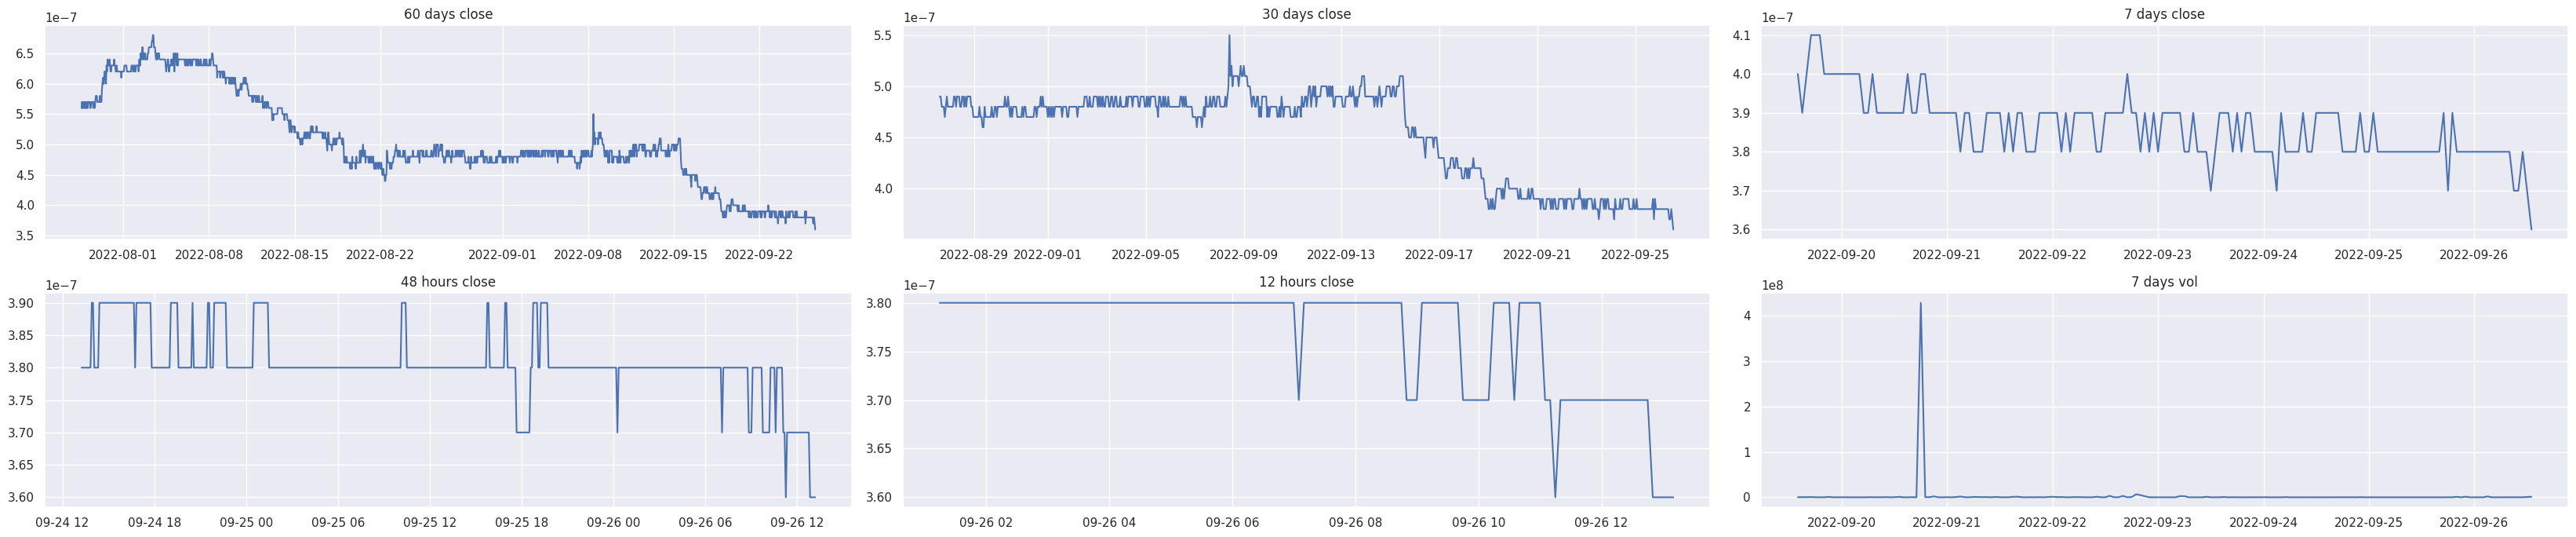

In [221]:
df_5mn, df_1h = await screener.show("TCTBTC")

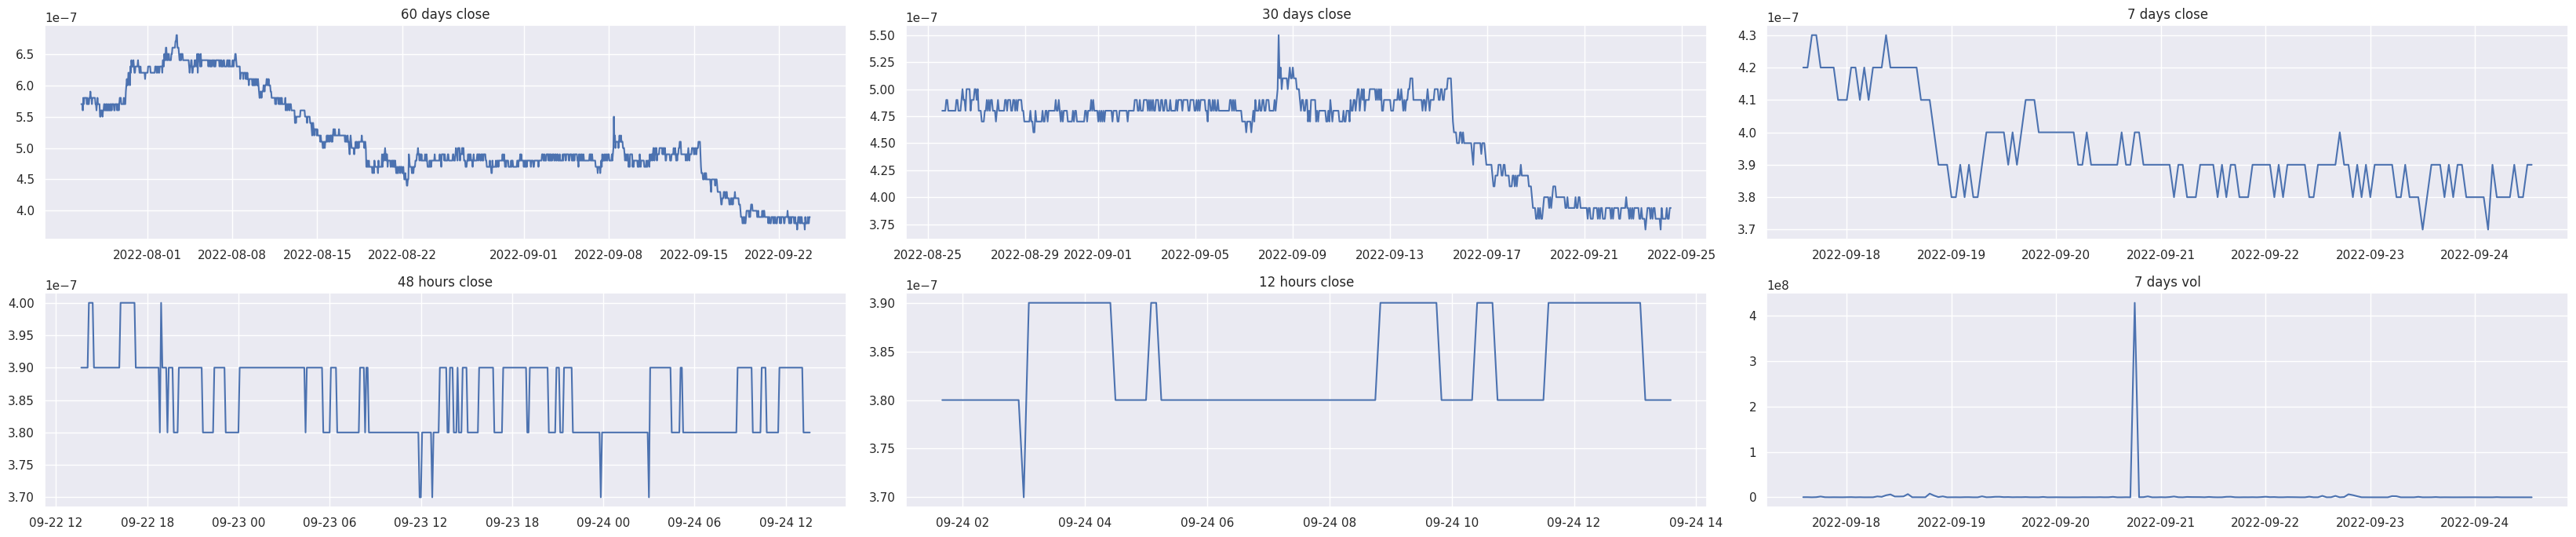

In [31]:
df_5mn, df_1h = await screener.show("TCTBTC")

In [10]:
df_1h = df_1h[df_1h.iloc[-1].name - timedelta(days=30):]
bounds = None
last = None
change = 0
verbose = 0
for value in df_1h.close.values:
    if not bounds:
        bounds = [value, value]
        if verbose: print("init")
        
    elif value not in bounds:
        if bounds[0] != bounds[1]:
            change += 1
            if verbose: print("change")
        
    if bounds and last and value < last:
        if verbose: print("down")
        bounds = [last, value]
    
    elif bounds and last and value > last:
        if verbose: print("up")
        bounds = [value, last]

    if verbose: print(value)
    last = value

print(f"{change=}")

change=88


In [58]:
from itertools import count
from pprint import pprint
data = {}
for i in list(range(30, 35))[::-1] + list(range(30, 37)):
    sleep(0.4)

    n = datetime.now()
    d = Decimal(f"{i}E-7")
    
    for price, last_datetime in list(data.items()):
        if last_datetime < n - timedelta(seconds=0.7):
            del data[price]
            print(f"Delete {price}")
        
    data[d] = n
    pprint(data)
    
print(min(data.keys()))
print(min(data.values()))
print(max(data.keys()))
print(max(data.values()))

{Decimal('0.0000034'): datetime.datetime(2022, 9, 24, 14, 4, 14, 318587)}
{Decimal('0.0000033'): datetime.datetime(2022, 9, 24, 14, 4, 14, 719332),
 Decimal('0.0000034'): datetime.datetime(2022, 9, 24, 14, 4, 14, 318587)}
Delete 0.0000034
{Decimal('0.0000032'): datetime.datetime(2022, 9, 24, 14, 4, 15, 120194),
 Decimal('0.0000033'): datetime.datetime(2022, 9, 24, 14, 4, 14, 719332)}
Delete 0.0000033
{Decimal('0.0000031'): datetime.datetime(2022, 9, 24, 14, 4, 15, 520866),
 Decimal('0.0000032'): datetime.datetime(2022, 9, 24, 14, 4, 15, 120194)}
Delete 0.0000032
{Decimal('0.0000030'): datetime.datetime(2022, 9, 24, 14, 4, 15, 921728),
 Decimal('0.0000031'): datetime.datetime(2022, 9, 24, 14, 4, 15, 520866)}
Delete 0.0000031
{Decimal('0.0000030'): datetime.datetime(2022, 9, 24, 14, 4, 16, 322434)}
{Decimal('0.0000030'): datetime.datetime(2022, 9, 24, 14, 4, 16, 322434),
 Decimal('0.0000031'): datetime.datetime(2022, 9, 24, 14, 4, 16, 723160)}
Delete 0.0000030
{Decimal('0.0000031'): date

In [ ]:
screener.format_screen_result(sr)

In [ ]:
screener.pairs["AMPBTC"]

In [ ]:
await screener.show("AMPBTC")

In [ ]:
await screener.show("AMPUSDT")

In [ ]:
await screener.show("BTCUSDT")

In [97]:
pairs = await controllers.binance.load_pairs()

In [ ]:
btcusdt = pairs["BTCUSDT"]
a = btcusdt.base_asset_precision

In [ ]:
Decimal(f"1E-{a}")

In [ ]:
Decimal(f"1E-{btcusdt.base_asset_precision}")
btcusdt

In [ ]:
pairs["AMPBTC"]

In [ ]:
pairs["COSBTC"].base_asset_atom_amount

In [ ]:
start_datetime_5mn = datetime.now() - timedelta(hours=48)
start_datetime_1h = datetime.now() - timedelta(days=14)
end_datetime = datetime.now()
        
df_5mn, df_1h = await asyncio.gather(
            controllers.binance.get_klines(
                pairs["AMPBTC"].symbol,
                interval="5m",
                start_datetime=start_datetime_5mn,
                end_datetime=end_datetime
            ),
            controllers.binance.get_klines(
                pairs["AMPBTC"].symbol,
                interval="1h",
                start_datetime=start_datetime_1h,
                end_datetime=end_datetime
            )
        )
...

In [ ]:
print("MAX    : ", df_1h.volumes.max())
print("MAX    : ", df_1h.volumes.min())
print("MEAN   : ", df_1h.volumes.mean())
print("MEDIAN : ", df_1h.volumes.median())
print("Q50    : ", df_1h.volumes.quantile(q=0.5))
print("Q90    : ", df_1h.volumes.quantile(q=0.9))
print("Q95    : ", df_1h.volumes.quantile(q=0.95))

In [ ]:
current_prices = adapters.binance.get_prices()
coin_prices = current_prices.prices["AMPBTC"]
coin_prices.ask - coin_prices.bid
print(f"ask  = {coin_prices.ask:.9f}")
print(f"bid  = {coin_prices.bid:.9f}")
print(f"diff = {coin_prices.ask - coin_prices.bid:.9f}")


In [ ]:
from analyst.bot import TickerData

adapters.binance_websocket.open()
adapters.binance_websocket.subscribe(["ampbtc@ticker"])
print(adapters.binance_websocket.receive())
print(adapters.binance_websocket.receive())
print(TickerData(**adapters.binance_websocket.receive()["data"]))
adapters.binance_websocket.close()

In [ ]:
summary.account

In [ ]:

class TickerData(BaseModel):
    timestamp: datetime
    symbol: str = Field(alias="s")
    last_price: float = Field(alias="c")
    best_ask_price: float = Field(alias="a")
    best_ask_quantity: float = Field(alias="A")
    best_bid_price: float = Field(alias="b")
    best_bid_quantity: float = Field(alias="B")
    trades: int = Field(alias="n")
    
    @property
    def spread(self):
        return self.best_ask_price - self.best_bid_price
    
    def has_ask_bid_prices_changed(self, other: TickerData) -> bool:
        return (
            self.last_price != other.last_price or
            self.best_ask_price != other.best_ask_price or
            self.best_bid_price != other.best_bid_price
        )
    
running = False

class MarketMakerStrategy:
    def __init__(self, symbol):
        self.symbol = symbol
        self.last_ticker_data: Optional[TickerData] = None
        
    def set_ticker_data(self, ticker_data: TickerData):
        if not self.last_ticker_data:
            pass
        elif ticker_data.has_ask_bid_prices_changed(self.last_ticker_data):
            print(ticker_data)

        self.last_ticker_data = ticker_data
        
    @property
    def subscribe_to(self):
        return {
            f"{self.symbol.lower()}@ticker": "ticker_data"
        }


class StrategyRunner:
    def __init__(self, adapters: Adapters):
        self.adapters = adapters
        self.streams_to_strategy = defaultdict(list)
        self.subscribe_to_streams = set()
        self.running = False

    def add_strategies(self, strategies):
        for strategy in strategies:
            for stream_name in strategy.subscribe_to.keys():
                self.subscribe_to_streams.add(stream_name)
                self.streams_to_strategy[stream_name].append(strategy)

    def stop(self):
        self.running = False
        self.adapters.binance_websocket.close()

    def run(self):
        self.adapters.binance_websocket.open()

        self.adapters.binance_websocket.subscribe(self.subscribe_to_streams)
        self.subscribe_to_streams = set()
        
        self.running = True

        last_prices = {}
        
        #while self.running:
        for i in range(4):
            try:
                data = self.adapters.binance_websocket.receive()
                
                if "stream" in data and "@ticker" in data["stream"]:
                    stream = data["stream"]
                    ticker_data = TickerData(**data["data"])
                    
                    last_prices[ticker_data.symbol] = ticker_data
                    
                    print(".", end="", flush=True)
                    
                    for strategy in self.streams_to_strategy.get(stream):
                        strategy.set_ticker_data(ticker_data)
            except KeyboardInterrupt:
                self.running = False
                print("Quitting")
            except Exception as exc:
                print("EXCEPTION")
                print(str(exc))
                break

strategies = [
    MarketMakerStrategy("AMPBTC")
]
runner = StrategyRunner(adapters=adapters)
runner.add_strategies(strategies)
runner.run()

In [ ]:
session = adapters.binance.session
resp = session.post(settings.binance_settings.api_url + "/api/v3/userDataStream")


In [ ]:
resp.json()

In [ ]:
i = 0
for a in controllers.binance.listen_user_data_streams():
    print(a)
    i += 1
    if i > 4:
        break

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep


class MarketMakerStrategy:
    def __init__(self, symbol):
        self.symbol = symbol
        self.last_ticker_data: Optional[TickerData] = None
        
    def set_ticker_data(self, ticker_data: TickerData):
        if not self.last_ticker_data:
            pass
        elif ticker_data.has_ask_bid_prices_changed(self.last_ticker_data):
            print(ticker_data)

        self.last_ticker_data = ticker_data
        
    @property
    def subscribe_to(self):
        return {
            f"{self.symbol.lower()}@ticker": "ticker_data"
        }

class MarketMaker:
    def __init__(self):
        self.amounts = {}
        self.strategies = {}
    def add_symbol(self, symbol, amount):
        if symbol in self.amounts:

        self.amounts[symbol] = amount
        self.strategies[f""]


In [ ]:
a = controllers.binance.load_prices()
a["AMPBTC"]

In [ ]:
a

In [ ]:

def lmao(label: str, length: int, to_sleep: int):
    for i in range(length):
        print(f"{label=} {i} sleeping {to_sleep}")
        sleep(to_sleep)
    print(f"Finished {label}")

executor = ThreadPoolExecutor(max_workers=3)
executor.submit(lmao, "A", 1, 6)
executor.submit(lmao, "B", 2, 3)
executor.submit(lmao, "C", 3, 2)
executor.submit(lmao, "D", 4, 1)

In [ ]:
pairs = await controllers.binance.load_pairs()

In [ ]:
pairs["AMPBTC"]

In [ ]:
book = await (await (await adapters.binance.get_session()).get(settings.binance.api_url + "/api/v3/depth", params={"symbol": "AMPBTC"})).json()
book

In [ ]:
plt.plot(df)
plt.show()

In [ ]:
class OrderBook(BaseModel):
    asks: DataFrame
    bids: DataFrame
        
    class Config:
        arbitrary_types_allowed = True

def book_side_to_dataframe(book_side_data, column_name): 
    converted_book_side_data = [
        [float(price), float(amount)]
        for price, amount in book_side_data
    ]
    df = DataFrame(converted_book_side_data, columns=("price", column_name))
    df.set_index("price", inplace=True)
    df.sort_values("price", ascending=False, inplace=True)

    return df
    
asks = book_side_to_dataframe(book["asks"], "asks")
bids = book_side_to_dataframe(book["bids"], "bids")

df = pd.concat([asks, bids], axis=0)
df.sort_values("price", ascending=False, inplace=True)
df

In [ ]:
list(dff.amount)

In [ ]:
dff

In [ ]:
len(dff.amount)

In [ ]:
list(asks.amount)

In [ ]:
dff = concat([asks, bids], axis=0)
plt.plot(list(asks.amount))
plt.show()

In [ ]:
from pprint import pprint
for s in await controllers.mongo.get_orders(symbol="AMPBTC"):
    pprint(s.dict())

In [ ]:
for s in await controllers.mongo.get_strategies():
    pprint(s.dict())

In [ ]:
await controllers.mongo.get_order(9117919, "AMPBTC")

In [ ]:
s

In [ ]:
await controllers.mongo.load_account()

In [ ]:
(await controllers.mongo.get_strategies(key={"$regex": "AMPBTC"}))[0].dict()

In [ ]:
lock = asyncio.Lock()
async def test(text):
    async with lock:
        await asyncio.sleep(1)
        print(f"{text}")
await asyncio.gather(
    test("lmao1"),
    test("lmao2"),
    test("lmao3"),
)

In [ ]:
for i in await controllers.binance.list_orders("COSBTC"):
    if i.status != "CANCELED":
        pprint(i.dict())

In [ ]:
a = DataFrame.from_dict({"a": [3, 5, 7], "b": [2, 2, 4]})
b = DataFrame.from_dict({"a": [2, 3, 4], "b": [2, 4, 3]})

now1 = datetime.now()
now2 = now1 + timedelta(days=1)
now3 = now1 + timedelta(days=2)

a.index = [now1, now1, now2]
b.index = [now1, now2, now3]

In [ ]:
a

In [ ]:
b

In [ ]:
res = DataFrame()
for k, v in a.items():
    print(k, v)

In [ ]:
from pprint import pprint
btcusdt = pairs["BTCUSDT"]
#pprint(btcusdt.dict())
btcusdt.ask_price * Decimal(0.0003)
btcusdt.ask_price / Decimal(100)
print(f"{Decimal(300) / btcusdt.ask_price=}")
print(f"{btcusdt.ask_price * Decimal(0.0015)=}")


In [ ]:
await controllers.binance.load_account()

In [ ]:
strats = await repositories.strategies.list()
len(strats)

In [ ]:
strat = strats[0]
strat

In [ ]:
strat.dict()

In [104]:


for base in ("AMP", "COS", "LINA", "JASMY", "STMX", "TCT"):
    btc_symbol = f"{base}BTC"
    usdt_symbol = f"{base}USDT"
    
    print(btc_symbol)#, usdt_symbol)
    #btc_pair = pairs[btc_symbol]
    #usdt_pair = pairs[usdt_symbol]
    #print(btc_pair)
    #print(usdt_pair)
    #await screener.show(btc_symbol)
    #await screener.show(usdt_symbol)
    
    pair = pairs[btc_symbol]
    print(pair.symbol, pair.quote_min_amount)

AMPBTC
AMPBTC 0.0001
COSBTC
COSBTC 0.0001
LINABTC
LINABTC 0.0001
JASMYBTC
JASMYBTC 0.0001
STMXBTC
STMXBTC 0.0001
TCTBTC
TCTBTC 0.0001


In [105]:
strat = (await controllers.mongo.get_strategies())[0]

In [107]:
pprint(strat.dict())

{'args': {'amount': Decimal('0.0015'),
          'internal_buy_order_ids': {UUID('2d9dc124-393b-472a-aeb6-295299db3930'),
                                     UUID('7914c987-36dc-4958-ba0a-decbd105891a')},
          'internal_sell_order_ids': {UUID('8e50c5c4-45fc-4b56-9702-99daa893d437'),
                                      UUID('d612dc8d-acc6-432c-b28d-ded526426adb')},
          'symbol': 'AMPBTC'},
 'created_at': datetime.datetime(2022, 9, 21, 22, 45, 6),
 'flags': <Flags() bits=0x0000>,
 'id': UUID('30c0bb29-48d9-4ddd-a256-5eb6b66f4cec'),
 'key': 'AMPBTC:0.0015',
 'name': 'market_maker',
 'state': <StrategyState.running: 0>,
 'updated_at': datetime.datetime(2022, 9, 21, 22, 45, 6),
 'version': 'v2'}


In [108]:
strat.amount = Decimal("0.0002")
await controllers.mongo.store_strategy(strat)

In [109]:
pairs["JASMYBTC"]

Pair(base='JASMY', quote='BTC', quote_min_amount=Decimal('0.0001'), base_asset_precision=8, quote_asset_precision=8, min_quantity=Decimal('0.1'), max_quantity=Decimal('92141578.0'), step_size=Decimal('0.1'), ask_price=Decimal('3.8E-7'), bid_price=Decimal('3.7E-7'), ask_quantity=Decimal('18683053.70000000'), bid_quantity=Decimal('10947230.70000000'))

In [169]:
s = (await controllers.mongo.get_strategies(key={"$regex": "TCT"}))[0]

In [170]:
pprint(s.dict())

{'args': {'amount': Decimal('0.0002'),
          'internal_buy_order_ids': {UUID('7bc521dd-a399-40c8-aeb6-10520f0ab1ee')},
          'internal_sell_order_ids': {UUID('6cfe0939-8133-4d3f-98e7-9f424bd4e284')},
          'symbol': 'TCTBTC'},
 'created_at': datetime.datetime(2022, 9, 24, 18, 30, 46),
 'flags': <Flags() bits=0x0000>,
 'id': UUID('8059dee5-0032-4bd3-9991-2218e6fbcc44'),
 'key': 'TCTBTC:0.0002',
 'name': 'market_maker',
 'state': <StrategyState.running: 0>,
 'updated_at': datetime.datetime(2022, 9, 24, 18, 30, 46),
 'version': 'v2'}


In [171]:
remove_orders = []
for i, order in enumerate(await controllers.mongo.get_orders(strategy_id=s.id)):
    print(i, order.internal_id, order.id, order.price, order.side, order.status)


0 77f3e4ed-89d8-49c4-bebf-0b0c74cdd5c1 32037760 3.8E-7 BUY FILLED
1 7bc521dd-a399-40c8-aeb6-10520f0ab1ee 32037761 3.7E-7 BUY NEW
2 6cfe0939-8133-4d3f-98e7-9f424bd4e284 32039874 3.9E-7 SELL NEW


In [146]:
for id in s.internal_buy_order_ids:
    print(id)
    await order_manager.setup_order(id)

49238b1a-a1af-4988-884a-106fd9464884
39eaeafb-c437-411f-9b82-2003621ca6e4


In [164]:
s.internal_buy_order_ids.remove(UUID("39eaeafb-c437-411f-9b82-2003621ca6e4"))

In [145]:
s.get_buy_orders(order_manager)

{}

In [165]:
await controllers.mongo.store_strategy(s)

In [252]:
get_filled = lambda os: list(filter(lambda o: o.status == ["FILLED", "CANCELED"], os))
get_unfilled = lambda os: list(filter(lambda o: o.status not in ["FILLED", "CANCELED"], os))
get_buy = lambda os: list(filter(lambda o: o.side == "BUY", os))
get_sell = lambda os: list(filter(lambda o: o.side == "SELL", os))
get_ids = lambda os: set([o.internal_id for o in os])

def get_by_price(orders):
    orders_by_price = defaultdict(list)
    for order in orders:
        orders_by_price[order.price].append(order)
    return orders_by_price

sort_by_price = lambda os: sorted(os.items(), key=lambda x: x[0], reverse=True)

all_invested = Decimal()
all_gained = Decimal()
all_orders = []

""" # UPDATE CURRENT ORDERS
for strategy in await controllers.mongo.get_running_strategies():
    orders = await controllers.mongo.get_orders(
        strategy_id=strategy.id,
        status={"$nin": ["FILLED", "CANCELED"]}
    )
    for order in orders:
        new = await order_manager.fetch_and_update_order(order)
        if order.dict() != new.dict():
            pprint(new.dict())
"""


for strategy in await controllers.mongo.get_running_strategies():
    orders = await controllers.mongo.get_orders(strategy_id=strategy.id)
    
    filled_orders = get_filled(orders)
    unfilled_orders = get_unfilled(orders)
    buy_orders = get_buy(orders)
    sell_orders = get_sell(orders)
    changed = False

    print(
        strategy.get_key(),
        f"Orders={len(orders)}",
        f"filled={len(filled_orders)}",
        f"buy={len(buy_orders)}"
        f"sell={len(sell_orders)}"
    )
    for o in unfilled_orders:
        print(o.status)
    
    invested = Decimal()
    for order in get_buy(unfilled_orders):
        invested += order.requested_quantity * order.price
    all_invested += invested

    gained = Decimal()
    for order in get_sell(filled_orders):
        gained += order.executed_quantity * order.price
    all_gained += gained
    
    unfilled_buy = unfilled_orders

    if True:
        print(f"{invested=} {gained=}")
        print(f"strat buy={len(strategy.internal_buy_order_ids)}")
        print(f"strat sell={len(strategy.internal_sell_order_ids)}")
        for price, price_orders in sort_by_price(get_by_price(get_sell(unfilled_orders))):
            print("SELL : ", price, len(price_orders))
        for price, price_orders in sort_by_price(get_by_price(get_buy(unfilled_orders))):
            print("BUY  : ",price, len(price_orders))
        
        print("unfilled buy")
        print(strategy.internal_buy_order_ids)
        print(get_ids(get_buy(unfilled_orders)))
        print(strategy.internal_buy_order_ids == get_ids(get_buy(unfilled_orders)))
        print("unfilled sell")
        print(strategy.internal_sell_order_ids)
        print(get_ids(get_sell(unfilled_orders)))
        print(strategy.internal_sell_order_ids == get_ids(get_sell(unfilled_orders)))
        
    all_orders += orders
    
    #if changed:
    #    await controllers.mongo.store_strategy(strategy)
    #print()
    #break
    
print(f"{all_gained=} {all_invested=}")

AMPBTC:0.0002 Orders=12 filled=0 buy=10sell=2
NEW
NEW
NEW
NEW
invested=Decimal('0.0003999200000000') gained=Decimal('0')
strat buy=2
strat sell=2
SELL :  2.7E-7 2
BUY  :  2.5E-7 1
BUY  :  2.4E-7 1
unfilled buy
{UUID('a4b1d2cb-ec8c-4dd1-ad58-c3ddaea22efa'), UUID('65b883ae-f368-4cb3-8d06-48c435713874')}
{UUID('a4b1d2cb-ec8c-4dd1-ad58-c3ddaea22efa'), UUID('65b883ae-f368-4cb3-8d06-48c435713874')}
True
unfilled sell
{UUID('d612dc8d-acc6-432c-b28d-ded526426adb'), UUID('8e50c5c4-45fc-4b56-9702-99daa893d437')}
{UUID('d612dc8d-acc6-432c-b28d-ded526426adb'), UUID('8e50c5c4-45fc-4b56-9702-99daa893d437')}
True
COSBTC:0.0002 Orders=5 filled=0 buy=3sell=2
NEW
NEW
NEW
NEW
invested=Decimal('0.0003996100000000') gained=Decimal('0')
strat buy=2
strat sell=2
SELL :  3.2E-7 1
SELL :  3.1E-7 1
BUY  :  3.0E-7 1
BUY  :  2.9E-7 1
unfilled buy
{UUID('3946a4e9-b972-4ac0-b162-e449b52de2e8'), UUID('d29b5a63-bfb6-44d6-8541-30c7df9b0ced')}
{UUID('3946a4e9-b972-4ac0-b162-e449b52de2e8'), UUID('d29b5a63-bfb6-44d6-8541

In [223]:
mongo_orders = await controllers.mongo.get_orders()

print(len(all_orders))
print(len(mongo_orders))

66
66
